In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy.stats import entropy
import networkit as nk #more efficient
import pickle
import statistics
from sklearn.utils import shuffle
from scipy.stats import pearsonr, spearmanr

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,time_series_henColumn_tsRow, is_WG_open, is_day
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_tracking_date = config.li_tracking_date
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'visual','3Dspace')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
EXP2_


In [4]:
path_extracted_data

'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_'

In [5]:
#with weight on the edge: TODO AND READ
#https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html

# download data

In [6]:
#new data
df_exp12 = pd.read_csv(os.path.join(path_extracted_data, 'df_bothexperiment.csv'), sep=',',
                         parse_dates=['level'], dayfirst=True) 
print(df_exp12.columns)
#keep nly the HA from the corresponding timestamps
df_exp12['severity'] = df_exp12.apply(lambda x: x[x['HAID']+'_severity'], axis=1)
df_exp12['gap'] = df_exp12.apply(lambda x: x[x['HAID']+'_gap'], axis=1)
df_exp12['IsOFH'] = df_exp12['Treatment'].map(lambda x: x=='OFH')
display(df_exp12[['HA1_severity', 'HA2_severity','HA3_severity', 'HA4_severity','HA5_severity','severity','HAID']])
print(df_exp12.shape)
display(df_exp12.head(3))

Index(['DOA', 'Period_type', 'PenID', 'Is_relocated', 'time2event', 'level',
       'early_death', 'HenID', 'RPenID', 'Is2Experiment', 'Treatment',
       'vertical_travel_distance', 'duration_5_Zone_min',
       'duration_2_Zone_min', 'mid_cum_Z4_h_Morning', 'WentinWG', 'HA1_weight',
       'HA2_weight', 'HA3_weight', 'HA4_weight', 'HA1_severity',
       'HA2_severity', 'HA3_severity', 'HA4_severity', 'HA1_gap', 'HA2_gap',
       'HA3_gap', 'HA4_gap', 'HA1_FeatherDamage', 'HA2_FeatherDamage',
       'HA3_FeatherDamage', 'HA4_FeatherDamage', 'ExperimentID',
       'daytimeduration', 'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight',
       'HA5_gap', 'HAID', 'VTDperhour', 'proptime_2_Zone', 'proptime_5_Zone'],
      dtype='object')


,HA1_severity,HA2_severity,HA3_severity,HA4_severity,HA5_severity,severity,HAID
0,0.0,0.0,1.0,18.0,NaN,0.0,HA1
1,0.0,0.0,1.0,18.0,NaN,0.0,HA1
2,0.0,0.0,1.0,18.0,NaN,0.0,HA1
3,0.0,0.0,1.0,18.0,NaN,0.0,HA1
4,0.0,0.0,1.0,18.0,NaN,0.0,HA1
...,...,...,...,...,...,...,...
8548,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8549,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8550,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8551,14.0,20.0,14.0,16.0,32.0,32.0,HA5


(8553, 45)


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Is2Experiment,...,HA5_severity,HA5_weight,HA5_gap,HAID,VTDperhour,proptime_2_Zone,proptime_5_Zone,severity,gap,IsOFH
0,167,R1,pen10,1,7,2021-11-23,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,NaN,HA1,3.185185,66.168724,2.014403,0.0,0.0,False
1,168,R1,pen10,1,6,2021-11-24,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,NaN,HA1,3.555556,50.691358,21.448560,0.0,0.0,False
2,169,R1,pen10,1,5,2021-11-25,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,NaN,HA1,4.592593,59.014403,6.802469,0.0,0.0,False


Index(['timepoint', 'group', 'age', 'day', 'date', 'file', 'pen', 'hybrid',
       'hen', 'severity', 'gap', 'durationC1', 'durationC2', 'durationC3',
       'durationC4', 'durationC5', 'durationC14', 'numberC1', 'numberC2',
       'numberC3', 'numberC4', 'numberC5', 'meanboutM1', 'medianboutM1',
       'meanboutM2', 'medianboutM2', 'meanboutM3', 'medianboutM3',
       'meanboutM4', 'medianboutM4', 'meanboutM5', 'medianboutM5', 'distance',
       'meanchange', 'mean1', 'medianchange', 'transitions', 'real0', 'sumdur',
       'nest_vs_total', 'PenID'],
      dtype='object')

pen1    1320
pen3    1320
pen5    1320
pen2    1320
pen4    1320
pen6    1320
Name: PenID, dtype: int64

pen5    1320
pen4    1320
pen6    1320
Name: PenID, dtype: int64

(3960, 50)


,daytimeduration,distance,VTDperhour,group,duration_2_Zone_min,duration_5_Zone_min,proptime_2_Zone,proptime_5_Zone
240,16,46.0,2.875,A,96.783333,0.00,10.081597,0.000000
241,16,64.0,4.000,A,205.733333,0.35,21.430556,0.036458
242,16,58.0,3.625,A,124.483333,0.00,12.967014,0.000000


,timepoint,group,age,day,date,file,pen,hybrid,hen,severity,...,PenID,HenID,duration_2_Zone_min,duration_5_Zone_min,daytimeduration,ExperimentID,VTDperhour,proptime_2_Zone,proptime_5_Zone,Treatment
240,1,A,21,1,2016-10-27,1A41,5,LB,41,35.0,...,pen5,EXP3_hen_41,96.783333,0.00,16,Exp3,2.875,10.081597,0.000000,groupA
241,1,A,21,2,2016-10-28,1A41,5,LB,41,35.0,...,pen5,EXP3_hen_41,205.733333,0.35,16,Exp3,4.000,21.430556,0.036458,groupA
242,1,A,21,3,2016-10-29,1A41,5,LB,41,35.0,...,pen5,EXP3_hen_41,124.483333,0.00,16,Exp3,3.625,12.967014,0.000000,groupA


,DOA,age,date,group
240,142,21,2016-10-27,A
241,143,21,2016-10-28,A
242,144,21,2016-10-29,A
243,145,21,2016-10-30,A
244,146,21,2016-10-31,A
...,...,...,...,...
7915,432,62,2017-08-13,B
7916,433,62,2017-08-14,B
7917,434,62,2017-08-15,B
7918,435,62,2017-08-16,B


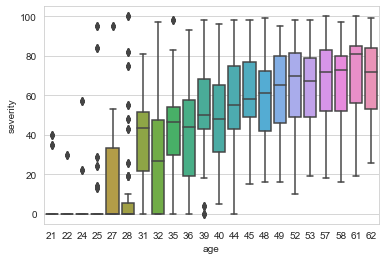

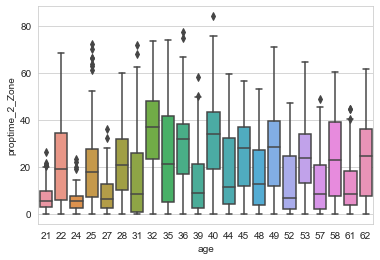

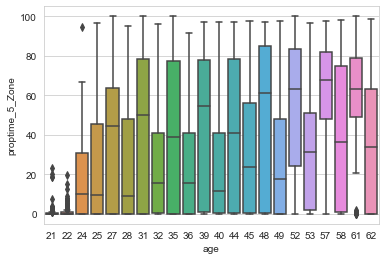

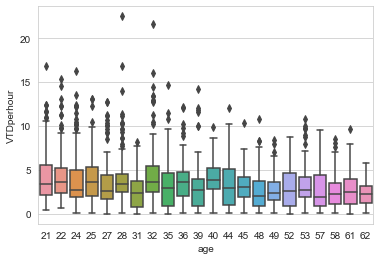

In [7]:
#past experiment
df_exp3 = pd.read_excel(os.path.join(path_extracted_data,'Mo_Masterfile.xlsx'),index_col=False)
df_exp3['PenID'] = df_exp3['pen'].map(lambda x: 'pen'+str(x))
display(df_exp3.columns)
#check penID
display(df_exp3['PenID'].value_counts())
df_exp3 = df_exp3[df_exp3['hybrid']=='LB']
display(df_exp3['PenID'].value_counts())
df_exp3['HenID'] = df_exp3['hen'].map(lambda x: 'EXP3_hen_'+str(x))
df_exp3['severity'] = df_exp3['severity'].map(lambda x: x*10) #scale as in our experiment
df_exp3['duration_2_Zone_min'] = df_exp3['durationC2'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_5_Zone_min'] = df_exp3['durationC5'].map(lambda x: x/60) #scale as in our experiment
df_exp3['daytimeduration'] = 16
df_exp3['ExperimentID'] = 'Exp3'
df_exp3['VTDperhour'] = df_exp3['distance'] /df_exp3['daytimeduration']
df_exp3['proptime_2_Zone'] = df_exp3['duration_2_Zone_min'] / (df_exp3['daytimeduration']*60) *100
df_exp3['proptime_5_Zone'] = df_exp3['duration_5_Zone_min'] / (df_exp3['daytimeduration']*60) *100
df_exp3['Treatment'] = df_exp3['group'].map(lambda x: 'group'+x)
print(df_exp3.shape)
display(df_exp3[['daytimeduration','distance','VTDperhour','group',
                 'duration_2_Zone_min','duration_5_Zone_min','proptime_2_Zone','proptime_5_Zone']].head(3))

#extract DOA (instead of the age here beeing weeks of age)
display(df_exp3.head(3))
df_exp3[df_exp3['age']==21]['date'].unique() 
#if hens were 21 week of age during these 6 days, lets assume they became 21WOA on the previous day : 
#dt.datetime(2016,10,26) hens were 141
#BUT BETTER: ask Rufener if she knows
df_exp3['DOA'] = df_exp3['date'].map(lambda x: int(141+(x-dt.datetime(2016,10,26)).days))
display(df_exp3[['DOA','age','date','group']])

df_exp3['early_death'] = 0 #to check with Christina
df_exp3['time2event'] = df_exp3['day'].map(lambda x: 7-x)
df_exp3['IsOFH'] = 0
df_exp3['Is_relocated'] = 0

df_exp3.rename(columns={'timepoint':'HAID'}, inplace=True)
df_exp3['HAID'] = df_exp3['HAID'].map(lambda x: 'HA'+str(int(x)))
df_exp3['HAID'] = df_exp3.apply(lambda x: x['HAID']+x['group'], axis=1)
sns.boxplot(x='age',y='severity', data=df_exp3)
plt.show();
sns.boxplot(x='age',y='proptime_2_Zone', data=df_exp3)
plt.show();
sns.boxplot(x='age',y='proptime_5_Zone', data=df_exp3)
plt.show();
sns.boxplot(x='age',y='VTDperhour', data=df_exp3)
plt.show();

In [8]:
df_haage = df_exp3.groupby(['HAID'])['DOA'].agg(lambda x: max(set(x))+1).reset_index() #KBF done on the day after
df_haage['HAID'] = df_haage['HAID'].map(lambda x: 'Exp3_'+x)
display(df_haage)
dico_haexp3_age = dict(zip(df_haage['HAID'].tolist(),df_haage['DOA'].tolist()))
dico_haexp3_age

,HAID,DOA
0,Exp3_HA10A,400
1,Exp3_HA10B,409
2,Exp3_HA11A,428
3,Exp3_HA11B,437
4,Exp3_HA1A,148
5,Exp3_HA1B,156
6,Exp3_HA2A,169
7,Exp3_HA2B,177
8,Exp3_HA3A,190
9,Exp3_HA3B,198


{'Exp3_HA10A': 400,
 'Exp3_HA10B': 409,
 'Exp3_HA11A': 428,
 'Exp3_HA11B': 437,
 'Exp3_HA1A': 148,
 'Exp3_HA1B': 156,
 'Exp3_HA2A': 169,
 'Exp3_HA2B': 177,
 'Exp3_HA3A': 190,
 'Exp3_HA3B': 198,
 'Exp3_HA4A': 218,
 'Exp3_HA4B': 226,
 'Exp3_HA5A': 246,
 'Exp3_HA5B': 254,
 'Exp3_HA6A': 274,
 'Exp3_HA6B': 282,
 'Exp3_HA7A': 317,
 'Exp3_HA7B': 325,
 'Exp3_HA8A': 337,
 'Exp3_HA8B': 345,
 'Exp3_HA9A': 365,
 'Exp3_HA9B': 373}

In [9]:
#exp2
birth_date = dt.datetime(2021,6,9) #DOA 1 = 2021-6-10
li_ = [dt.datetime(2021,11,30), dt.datetime(2022,2,8), dt.datetime(2022,4,12), dt.datetime(2022,7,5)]
print([(i-birth_date).days for i in li_])
#exp1:
birth_date = dt.datetime(2020,6,3) #DOA 1 = 2020-6-4
li_ = [dt.datetime(2020,11,23), dt.datetime(2021,1,4), dt.datetime(2021,2,1),
               dt.datetime(2021,4,12), dt.datetime(2021,7,26)]
print([(i-birth_date).days for i in li_])

dico_haexp12_age = {'Exp2_HA1': 174,'Exp2_HA2': 244,'Exp2_HA3': 307,'Exp2_HA4': 391,
                    'Exp1_HA1':173, 'Exp1_HA2':215,'Exp1_HA3':243,'Exp1_HA4':313,'Exp1_HA5':418}
dico_ha_age = {**dico_haexp3_age, **dico_haexp12_age}
dico_ha_age
#lets define start date of study as 215, to inlude four timestamp from the studies, except exp 1 as to much correlated with time 
doa_studystarted = 190 #min(dico_ha_age.values()) #lets consider all for now 190
doa_studystarted

[174, 244, 307, 391]
[173, 215, 243, 313, 418]


190

In [10]:
print(min(dico_ha_age.values()),max(dico_ha_age.values()),
      round(np.mean(list(dico_ha_age.values())),2),np.median(list(dico_ha_age.values())))

148 437 282.32 274.0


# combine together

In [13]:
######################################################################################
#concat both dataset
li_mvtha = ['VTDperhour','proptime_2_Zone','proptime_5_Zone','severity','gap']
li_info = ['HenID','early_death','ExperimentID','DOA','time2event','HAID','Is_relocated','IsOFH']
print(df_exp12.shape)
#display(df_exp12[li_mvtha+li_info].head(2))
print(df_exp3.shape)
#display(df_exp3[li_mvtha+li_info].head(2))
df = pd.concat([df_exp12[li_mvtha+li_info+['mid_cum_Z4_h_Morning']], df_exp3[li_mvtha+li_info]])
print(df.shape)
display(df.head(2))

(8553, 45)
(3960, 55)
(12513, 14)


,VTDperhour,proptime_2_Zone,proptime_5_Zone,severity,gap,HenID,early_death,ExperimentID,DOA,time2event,HAID,Is_relocated,IsOFH,mid_cum_Z4_h_Morning
0,3.185185,66.168724,2.014403,0.0,0.0,EXP2_hen_1,0.0,Exp2,167,7,HA1,1,0,5.365556
1,3.555556,50.691358,21.448560,0.0,0.0,EXP2_hen_1,0.0,Exp2,168,6,HA1,1,0,5.242778


In [14]:
######################################################################################
#add usefull var
df['IsOFH'] = df['IsOFH'].map(lambda x: int(x))
df['Is_exp3'] = df['ExperimentID'].map(lambda x: int(x=='Exp3'))
df['Is_exp2'] = df['ExperimentID'].map(lambda x: int(x=='Exp2'))
df['Is_exp1'] = df['ExperimentID'].map(lambda x: int(x=='Exp1'))
display(df[['IsOFH','ExperimentID', 'Is_relocated','Is_exp1','Is_exp2','Is_exp3']])
df['DOAHA'] = df.apply(lambda x: dico_ha_age[x['ExperimentID']+'_'+x['HAID']], axis=1)

######################################################################################
print('---------------- remove any NA in severity of VTDperhour')
display(df.isna().sum(axis=0).sort_values())
print(df.shape)
df = df[~df['VTDperhour'].isnull()]
print(df.shape)
print(df.shape)
df = df[~df['severity'].isnull()]
print(df.shape)
display(df.isna().sum(axis=0).sort_values())

######################################################################################
print('---------------- keep all DOA >=doa_studystarted, then add MonthInStudy')
df = df[df['DOAHA']>=doa_studystarted].copy()
print(df.shape)

######################################################################################
#MonthInstudy: the time when the measurement took place (e.g., in months from the beginning of the study)
df['MonthInstudy'] = df['DOAHA'].map(lambda x: round((x-doa_studystarted)/30.4167,2))
if df['MonthInstudy'].min()!=0:
    print('error')
    sys.exit()
display(df.groupby('HenID')[['HAID','DOAHA','MonthInstudy']].agg(lambda x: sorted(set(x))).reset_index())
display(df.head(3))

,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,Is_exp3
0,0,Exp2,1,0,1,0
1,0,Exp2,1,0,1,0
2,0,Exp2,1,0,1,0
3,0,Exp2,1,0,1,0
4,0,Exp2,1,0,1,0
...,...,...,...,...,...,...
7915,0,Exp3,0,0,0,1
7916,0,Exp3,0,0,0,1
7917,0,Exp3,0,0,0,1
7918,0,Exp3,0,0,0,1


---------------- remove any NA in severity of VTDperhour


DOA                        0
Is_exp2                    0
Is_exp3                    0
IsOFH                      0
Is_relocated               0
HAID                       0
time2event                 0
Is_exp1                    0
DOAHA                      0
early_death                0
HenID                      0
ExperimentID               0
gap                      247
severity                 247
proptime_5_Zone          468
proptime_2_Zone          468
VTDperhour               468
mid_cum_Z4_h_Morning    4061
dtype: int64

(12513, 18)
(12045, 18)
(12045, 18)
(11982, 18)


VTDperhour                 0
Is_exp2                    0
Is_exp3                    0
IsOFH                      0
Is_relocated               0
HAID                       0
time2event                 0
Is_exp1                    0
DOA                        0
early_death                0
HenID                      0
gap                        0
severity                   0
proptime_5_Zone            0
proptime_2_Zone            0
ExperimentID               0
DOAHA                      0
mid_cum_Z4_h_Morning    3577
dtype: int64

---------------- keep all DOA >=doa_studystarted, then add MonthInStudy
(9072, 18)


,HenID,HAID,DOAHA,MonthInstudy
0,EXP1_hen_1,[HA2],[215],[0.82]
1,EXP1_hen_10,"[HA2, HA3, HA4, HA5]","[215, 243, 313, 418]","[0.82, 1.74, 4.04, 7.5]"
2,EXP1_hen_101,"[HA2, HA3, HA4, HA5]","[215, 243, 313, 418]","[0.82, 1.74, 4.04, 7.5]"
3,EXP1_hen_102,"[HA2, HA3, HA4, HA5]","[215, 243, 313, 418]","[0.82, 1.74, 4.04, 7.5]"
4,EXP1_hen_105,"[HA2, HA4]","[215, 313]","[0.82, 4.04]"
...,...,...,...,...
413,EXP3_hen_95,"[HA10B, HA11B, HA3B, HA4B, HA5B, HA6B, HA7B, H...","[198, 226, 254, 282, 325, 345, 373, 409, 437]","[0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, 7.2, ..."
414,EXP3_hen_96,"[HA10B, HA3B, HA4B, HA5B, HA6B, HA7B, HA8B, HA9B]","[198, 226, 254, 282, 325, 345, 373, 409]","[0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, 7.2]"
415,EXP3_hen_97,"[HA10B, HA11B, HA3B, HA4B, HA5B, HA6B, HA7B, H...","[198, 226, 254, 282, 325, 345, 373, 409, 437]","[0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, 7.2, ..."
416,EXP3_hen_98,"[HA10B, HA11B, HA3B, HA4B, HA5B, HA6B, HA7B, H...","[198, 226, 254, 282, 325, 345, 373, 409, 437]","[0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, 7.2, ..."


,VTDperhour,proptime_2_Zone,proptime_5_Zone,severity,gap,HenID,early_death,ExperimentID,DOA,time2event,HAID,Is_relocated,IsOFH,mid_cum_Z4_h_Morning,Is_exp3,Is_exp2,Is_exp1,DOAHA,MonthInstudy
1148,4.357143,73.182540,1.751984,0.0,0.0,EXP2_hen_1,0.0,Exp2,237,7,HA2,1,0,4.438056,0,1,0,244,1.78
1149,4.000000,65.394841,14.892857,0.0,0.0,EXP2_hen_1,0.0,Exp2,238,6,HA2,1,0,4.519444,0,1,0,244,1.78
1150,5.142857,63.904762,17.039683,0.0,0.0,EXP2_hen_1,0.0,Exp2,239,5,HA2,1,0,4.505000,0,1,0,244,1.78


In [16]:
######################################################################################
print('---------------- remove all the hens with only one or two measure')
df_sel = df.groupby('HenID')['HAID'].agg(lambda x: len(set(x))).reset_index()
li_hen2remove = df_sel[df_sel['HAID']<=2]['HenID'].tolist() #remove all the hens with only one or two measure
print(len(set(li_hen2remove)))
print(df.shape)
df = df[~df['HenID'].isin(li_hen2remove)]
print(df.shape)

######################################################################################
#remove hens with only one obs, model do not like it otherwise
print('---------------- remove hens with no SD')
df_ = df.groupby('HenID')[['severity','VTDperhour']].agg(lambda x: np.std(list(x))).reset_index()
display(df_[df_['severity']==0])
li_hen2remove = list(set(df_[df_['severity']==0]['HenID'].tolist()))
print(len(li_hen2remove))
df = df[~df['HenID'].isin(li_hen2remove)]
print(df.shape)

######################################################################################
#in ctsem documentation: "subject id (numeric values, 1 to max subjects)
print('---------------- now that we cleaned the data, lets add a subject id that comply with ctsem package in R to avoid potential confusion')
df_h = df[['HenID']].drop_duplicates()
df_h['id'] = range(1,df_h.shape[0]+1)
dico_henID_ctsemid = dict(zip(df_h['HenID'].tolist(),df_h['id'].tolist()))
df['id'] = df['HenID'].map(lambda x: dico_henID_ctsemid[x])
display(df[['HenID','id']].head(2))
display(df[['ExperimentID','HAID']].value_counts().reset_index())
display(df[['ExperimentID','MonthInstudy']].value_counts().reset_index())

######################################################################################
print('---------------- save with mvt every day and mean mvt per HA')
print(df.shape)
display(df.head(2))
df.to_csv(os.path.join(path_extracted_data,'df_longformatALLdaily.csv'), index=False, sep=',')
print(spearmanr(df['severity'].tolist(), df['MonthInstudy'].tolist()))
print(pearsonr(df['severity'].tolist(), df['MonthInstudy'].tolist()))
#groupby occasion to have a single mean mvt behaviour per occasion (as we have a single HA per occasion, happening at the end
#of each occasion)
df_longformat = df.groupby(['HAID','HenID','id','MonthInstudy','DOAHA','IsOFH','ExperimentID', 'Is_relocated','Is_exp1','Is_exp2','Is_exp3',
                            'early_death'])[['time2event','DOA','proptime_2_Zone','proptime_5_Zone','VTDperhour','mid_cum_Z4_h_Morning',
                                             'severity','gap']].mean().reset_index()
#check correlaiton --> account for age trend
print(spearmanr(df_longformat['severity'].tolist(), df_longformat['MonthInstudy'].tolist()))
print(pearsonr(df_longformat['severity'].tolist(), df_longformat['MonthInstudy'].tolist()))

####################
#We will have time reflecting age, we will create an empty observation row for every hen at the age of your earliest 
#observation -- so as not all hens had their healh assessed at doa_studystarted, we will create an observation at 148 DOA for all the 
#other hens and just set the observed variables to NA.
len(df_longformat[df_longformat['DOAHA']==doa_studystarted]['HenID'].unique())
#display(df_longformat.groupby('DOAHA')['HenID'].agg(lambda x: len(set(x))).reset_index()) #more details if we want more than 19 hens
li_firsthens = df_longformat[df_longformat['DOAHA']==doa_studystarted]['HenID'].tolist()
li_otherhens = [i for i in df_longformat['HenID'].unique() if i not in li_firsthens]
print(len(li_firsthens), len(df_longformat['HenID'].unique()), len(li_otherhens))
li_specifichens = ['HenID','id','IsOFH','ExperimentID','Is_relocated','Is_exp1','Is_exp2','Is_exp3','early_death']
dfhens = {'HenID': li_otherhens,
          'MonthInstudy':0,
          'DOAHA':doa_studystarted,
          'severity':np.nan,
          'VTDperhour':np.nan,
          'proptime_2_Zone':np.nan,
          'proptime_5_Zone':np.nan,
          'mid_cum_Z4_h_Morning':np.nan,
          'HAID':'created'}
df_2add = pd.DataFrame.from_dict(dfhens)
#add hens data
df_specifichens = df[li_specifichens].drop_duplicates()
if df_specifichens.shape[0]!=len(df_specifichens['HenID'].unique()):
    print('ERROR: some ind do not have unique values for at least one of the characteristics')
df_2add = pd.merge(df_2add, df_specifichens, on='HenID', how='left')
print(df_2add.shape)
display(df_2add.head(2))

print(df_longformat.shape)
df_longformat = pd.concat([df_longformat,df_2add])
print(df_longformat.shape, df_2add.shape)

#groupby fucked the id, lets sort by id
df_longformat.sort_values(['id','MonthInstudy'], inplace=True)
print(df_longformat.shape)
display(df_longformat.head(2))
df_longformat.to_csv(os.path.join(path_extracted_data,'df_longformatALL.csv'), index=False, sep=',')

---------------- remove all the hens with only one or two measure
76
(9072, 19)
(8316, 19)
---------------- remove hens with no SD


,HenID,severity,VTDperhour
7,EXP1_hen_111,0.0,0.789943
47,EXP1_hen_173,0.0,0.883333
159,EXP2_hen_129,0.0,0.501211
184,EXP2_hen_153,0.0,0.941271
193,EXP2_hen_161,0.0,0.926507
204,EXP2_hen_20,0.0,1.570265
251,EXP2_hen_68,0.0,0.934044
277,EXP2_hen_92,0.0,1.495361


8
(8164, 19)
---------------- now that we cleaned the data, lets add a subject id that comply with ctsem package in R to avoid potential confusion


,HenID,id
1148,EXP2_hen_1,1
1149,EXP2_hen_1,1


,ExperimentID,HAID,0
0,Exp2,HA3,1029
1,Exp2,HA4,1024
2,Exp2,HA2,920
3,Exp1,HA4,791
4,Exp1,HA2,774
5,Exp1,HA5,657
6,Exp3,HA4B,240
7,Exp3,HA5B,240
8,Exp3,HA3B,238
9,Exp3,HA8B,232


,ExperimentID,MonthInstudy,0
0,Exp2,3.85,1029
1,Exp2,6.61,1024
2,Exp2,1.78,920
3,Exp1,4.04,791
4,Exp1,0.82,774
5,Exp1,7.50,657
6,Exp3,1.18,240
7,Exp3,2.10,240
8,Exp3,0.26,238
9,Exp3,5.10,232


---------------- save with mvt every day and mean mvt per HA
(8164, 20)


,VTDperhour,proptime_2_Zone,proptime_5_Zone,severity,gap,HenID,early_death,ExperimentID,DOA,time2event,HAID,Is_relocated,IsOFH,mid_cum_Z4_h_Morning,Is_exp3,Is_exp2,Is_exp1,DOAHA,MonthInstudy,id
1148,4.357143,73.182540,1.751984,0.0,0.0,EXP2_hen_1,0.0,Exp2,237,7,HA2,1,0,4.438056,0,1,0,244,1.78,1
1149,4.000000,65.394841,14.892857,0.0,0.0,EXP2_hen_1,0.0,Exp2,238,6,HA2,1,0,4.519444,0,1,0,244,1.78,1


SpearmanrResult(correlation=0.42770643501281386, pvalue=0.0)
PearsonRResult(statistic=0.34724022366003593, pvalue=4.772948372370961e-230)
SpearmanrResult(correlation=0.4329638702100652, pvalue=2.0272481624351166e-64)
PearsonRResult(statistic=0.37055392199373327, pvalue=2.354610258710733e-46)
18 334 316
(316, 17)


,HenID,MonthInstudy,DOAHA,severity,VTDperhour,proptime_2_Zone,proptime_5_Zone,mid_cum_Z4_h_Morning,HAID,id,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,Is_exp3,early_death
0,EXP3_hen_100,0,190,NaN,NaN,NaN,NaN,NaN,created,314,0,Exp3,0,0,0,1,0.0
1,EXP3_hen_101,0,190,NaN,NaN,NaN,NaN,NaN,created,315,0,Exp3,0,0,0,1,0.0


(1386, 20)
(1702, 20) (316, 17)
(1702, 20)


,HAID,HenID,id,MonthInstudy,DOAHA,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,Is_exp3,early_death,time2event,DOA,proptime_2_Zone,proptime_5_Zone,VTDperhour,mid_cum_Z4_h_Morning,severity,gap
166,created,EXP2_hen_1,1,0.00,190,0,Exp2,1,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,HA2,EXP2_hen_1,1,1.78,244,0,Exp2,1,0,1,0,0.0,4.0,240.0,65.240079,11.952381,5.030612,4.624683,0.0,0.0


In [17]:
#lets define time as the number of month sign the first KBF, and each time beeing representative of the day of KBF, 
#not the day of mvt
df_longformat[['ExperimentID','HAID']].value_counts().reset_index()

,ExperimentID,HAID,0
0,Exp2,HA2,147
1,Exp2,HA3,147
2,Exp2,HA4,147
3,Exp2,created,147
4,Exp1,HA2,129
5,Exp1,created,129
6,Exp1,HA4,128
7,Exp1,HA5,113
8,Exp1,HA3,103
9,Exp3,HA5B,40


In [18]:
df_ = df_longformat.groupby('HenID')[['DOAHA','MonthInstudy']].agg(lambda x: sorted(list(x))).reset_index()
df_['DOAdiff'] = df_['DOAHA'].map(lambda x: [x[i+1]-x[i] for i in range(0,len(x)-1)])
df_

,HenID,DOAHA,MonthInstudy,DOAdiff
0,EXP1_hen_10,"[190, 215, 243, 313, 418]","[0.0, 0.82, 1.74, 4.04, 7.5]","[25, 28, 70, 105]"
1,EXP1_hen_101,"[190, 215, 243, 313, 418]","[0.0, 0.82, 1.74, 4.04, 7.5]","[25, 28, 70, 105]"
2,EXP1_hen_102,"[190, 215, 243, 313, 418]","[0.0, 0.82, 1.74, 4.04, 7.5]","[25, 28, 70, 105]"
3,EXP1_hen_106,"[190, 215, 313, 418]","[0.0, 0.82, 4.04, 7.5]","[25, 98, 105]"
4,EXP1_hen_107,"[190, 215, 243, 313, 418]","[0.0, 0.82, 1.74, 4.04, 7.5]","[25, 28, 70, 105]"
...,...,...,...,...
329,EXP3_hen_95,"[190, 198, 226, 254, 282, 325, 345, 373, 409, ...","[0.0, 0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, ...","[8, 28, 28, 28, 43, 20, 28, 36, 28]"
330,EXP3_hen_96,"[190, 198, 226, 254, 282, 325, 345, 373, 409]","[0.0, 0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, ...","[8, 28, 28, 28, 43, 20, 28, 36]"
331,EXP3_hen_97,"[190, 198, 226, 254, 282, 325, 345, 373, 409, ...","[0.0, 0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, ...","[8, 28, 28, 28, 43, 20, 28, 36, 28]"
332,EXP3_hen_98,"[190, 198, 226, 254, 282, 325, 345, 373, 409, ...","[0.0, 0.26, 1.18, 2.1, 3.02, 4.44, 5.1, 6.02, ...","[8, 28, 28, 28, 43, 20, 28, 36, 28]"


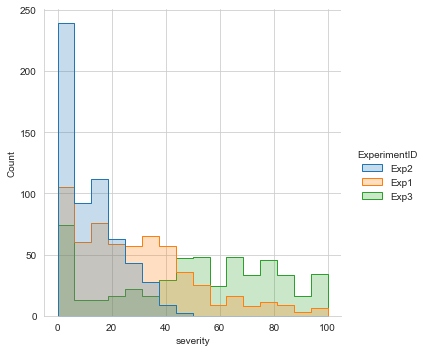

In [19]:
sns.displot(data=df_longformat,x='severity', hue='ExperimentID', element="step");

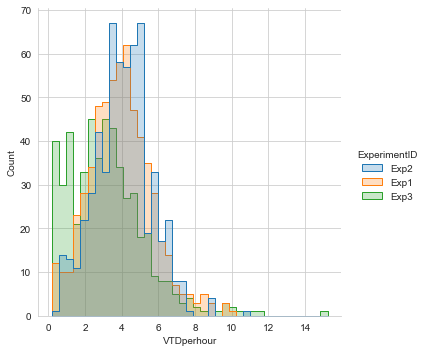

In [20]:
sns.displot(data=df_longformat,x='VTDperhour', hue='ExperimentID',element="step");

#Or eventually: but higher corr with time
df_longformat = df_longformat[(df_longformat['DOA']>200)|(df_longformat['ExperimentID']=='Exp2')].copy()
#df_longformat = df_longformat[df_longformat['ExperimentID']=='Exp3']
print(df_longformat.shape)
#df_longformat = df_longformat[~((df_longformat['DOA']<=250)&(df_longformat['ExperimentID']=='Exp3'))] #['HAID'].value_counts()
print(df_longformat.shape)
print(spearmanr(df_longformat['severity'].tolist(), df_longformat['time'].tolist()))
print(pearsonr(df_longformat['severity'].tolist(), df_longformat['time'].tolist()))

In [21]:
df_longformat['early_death'].value_counts()

0.0    1689
1.0      13
Name: early_death, dtype: int64

In [22]:
df_longformat['Is_relocated'].value_counts()

0    1406
1     296
Name: Is_relocated, dtype: int64

In [23]:
df_longformat['gap'].value_counts()

0.0    981
1.0    405
Name: gap, dtype: int64

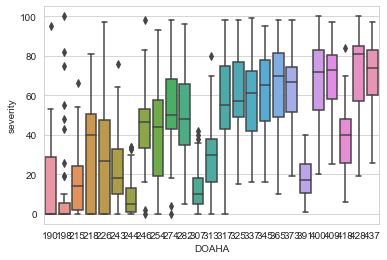

In [24]:
sns.boxplot(y='severity', x='DOAHA', data=df_longformat);

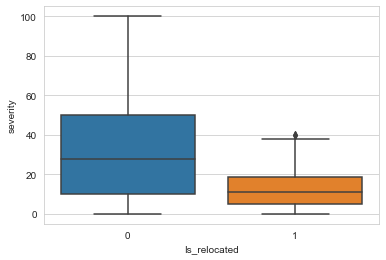

In [26]:
sns.boxplot(y='severity', x='Is_relocated', data=df_longformat);

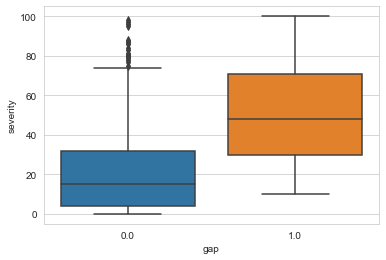

In [27]:
sns.boxplot(y='severity', x='gap', data=df_longformat);

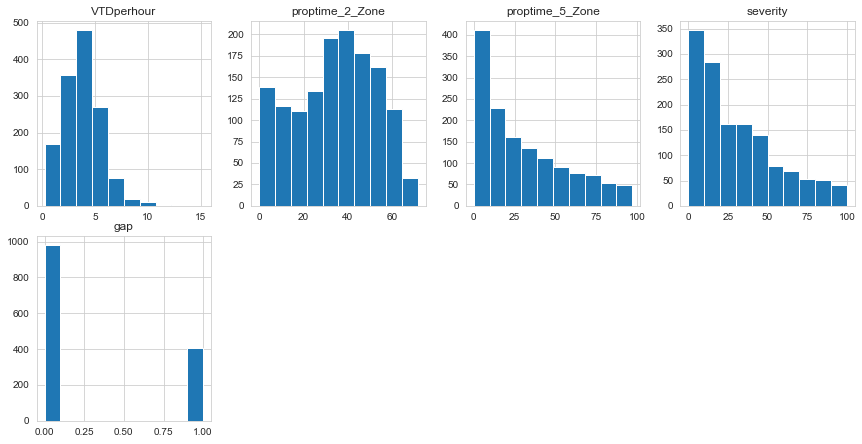

In [29]:
c = 4
l = len(li_mvtha)
fig = plt.figure(figsize=(3*c, 3*l))
for i,v in enumerate(li_mvtha):
    plt.subplot(l,c,i+1)
    plt.tight_layout()
    plt.hist(df_longformat[v]);
    plt.title(v)
    #plt.axis('off');

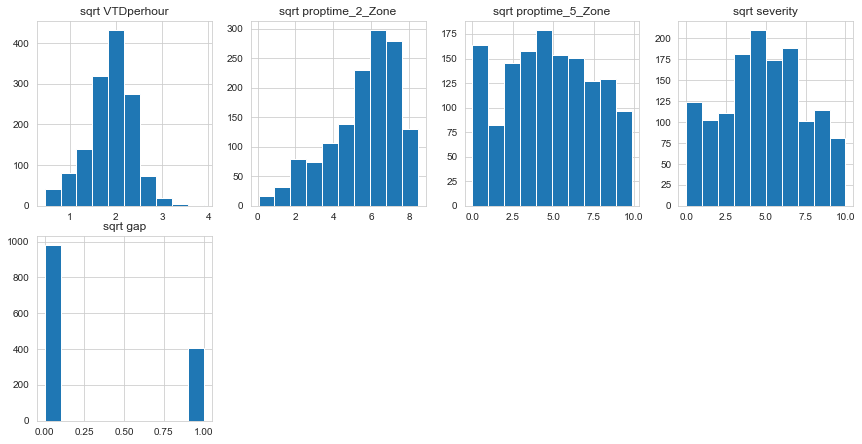

In [30]:
c = 4
l = len(li_mvtha)
fig = plt.figure(figsize=(3*c, 3*l))
for i,v in enumerate(li_mvtha):
    plt.subplot(l,c,i+1)
    plt.tight_layout()
    plt.hist(np.sqrt(df_longformat[v]));
    plt.title('sqrt '+v)
    #plt.axis('off');

In [38]:
df_longformat['ExperimentID'].value_counts()

Exp1    602
Exp2    588
Exp3    512
Name: ExperimentID, dtype: int64